## <font color="Blue">Phishing URL Detection - ConvXGB Model</font>

<b>GOAL:</b> This study employs new deep learning algorithm named "ConvXGB" to the field of cybersecurity in detecting phishing URL.</br>
<b>Author :</b> Saravanan Muthuramalingam </br>
<b>Purpose of this notebook :</b> This Notebook handles the following,
    <li> Hyperparamter Tuning </li>
    <li> EPOCH = 75 </li>
    <li> Dropout = 0.5 </li>
        <li> NO SMOTE but has Augmentation </li>

#### <NO SMOTE, but with Augmentation>

In [1]:
# import all required python libraries
#-------------------------------------#
# Statistics Libraries
import numpy as np

# Dataset related Libraires
import pandas as pd 
import csv

# Data Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# URL Parsing Libraries
import urllib.parse
from urllib.parse import urlparse
from urllib.parse import urlsplit
from urlpath import URL

# OS and regular expression Libraries
import re
import glob
import os

# Image processing related Libraries
from PIL import Image
import cv2
import skimage.measure
import imghdr

# Image validation related Libraries
from difPy import dif
from sklearn.preprocessing import OneHotEncoder

# To Build CNN in Keras 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, Adadelta, RMSprop

# XGBoost classification algorithm
from xgboost import XGBClassifier

# Perforrmance evaluation Librraries
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


#### <font color='blue'>7. Splitting Train/Test Data</font>

In [37]:
#spliting test and train
#80% of the datasets is reserved for training the model
raw_df = pd.read_csv(r'C:\Users\msara\Desktop\dataset\preprocessed_data.csv')
raw_df['split'] = np.random.randn(raw_df.shape[0], 1)



raw_df = raw_df.drop(['Unnamed: 0', 'split'],axis=1)
raw_df.shape

(17683, 785)

#### <font color='blue'>9. Train/Test Data Pre-processing</font>

In [38]:
msk = np.random.rand(len(raw_df)) <= 0.8

train = raw_df[msk]
test = raw_df[~msk]

In [39]:
#converting the data to appropripate shapes using numpy
train_data = train[:]
val_data = test[400:]
train_label = np.float32(train_data.result)
val_label = np.float32(val_data.result)
train_image = np.float32(train_data[train_data.columns[1:]])
val_image = np.float32(val_data[val_data.columns[1:]])
test_image = np.float32(test[test.columns[1:]])
test_label = np.float32(test.result)
print('train shape: %s'%str(train_data.shape))
print('val shape: %s'%str(val_data.shape))
print('train_label shape: %s'%str(train_label.shape))
print('val_label shape: %s'%str(val_label.shape))
print('train_image shape: %s'%str(train_image.shape))
print('val_image shape: %s'%str(val_image.shape))
print('test_image shape: %s'%str(test_image.shape))
print('test_label shape: %s'%str(test_label.shape))

train shape: (14123, 785)
val shape: (3160, 785)
train_label shape: (14123,)
val_label shape: (3160,)
train_image shape: (14123, 784)
val_image shape: (3160, 784)
test_image shape: (3560, 784)
test_label shape: (3560,)


In [40]:


plt.show()
print(train_image.shape)

train_image = train_image/255.0
val_image = val_image/255.0
test_image = test_image/255.0

print(train_image.shape)

train_image = train_image.reshape(train_image.shape[0],28,28,1)
val_image = val_image.reshape(val_image.shape[0],28,28,1)
test_image = test_image.reshape(test_image.shape[0],28,28,1)
print('train_image shape: %s'%str(train_image.shape))

print('train_image shape: %s'%str(train_image.shape))
print('val_image shape: %s'%str(val_image.shape))

train_label1 = train_label
val_label1 = val_label
print(val_label1.shape)

(14123, 784)
(14123, 784)
train_image shape: (14123, 28, 28, 1)
train_image shape: (14123, 28, 28, 1)
val_image shape: (3160, 28, 28, 1)
(3160,)


#### <font color='blue'>10. One Hot Encoding</font>

In [41]:
#onehot encoding
encoder = OneHotEncoder(sparse=False,categories='auto')
yy = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]
encoder.fit(yy)
# transform
train_label = train_label.reshape(-1,1)
val_label = val_label.reshape(-1,1)

train_label = encoder.transform(train_label)
val_label = encoder.transform(val_label)

print('train_label shape: %s'%str(train_label.shape))
print('val_label shape: %s'%str(val_label.shape))

train_label shape: (14123, 10)
val_label shape: (3160, 10)


#### <font color='blue'> 11. CNN Model Building </font>

In [42]:
#CNN Model Building
model = Sequential()
# input: 28x28 images with 1 channels -> (28, 28, 1) tensors.
#REason for having grey scale 1 channel
# https://stackoverflow.com/questions/53044116/difference-between-grayscale-images-represented-by-3-channels-and-1-channel-in-c#:~:text=The%20information%20given%20by%20the,take%20more%20time%20to%20compute
# this applies 32 convolution filters of size 3x3 each.
# First two convolution layer has 32 Feature Maps
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1),padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.10))

# Subsequent two convolution layer has 64 Feature Maps
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.10))

# Next two convolution layer has 128 Feature Maps
model.add(Conv2D(128, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.10))

# Final two convolution layer has 128 Feature Maps
model.add(Conv2D(256, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(256, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.10))


model.add(Flatten())


# Dense Layer
#model = keras.applications.inception_v3.InceptionV3(weights= None, include_top=False, input_shape= (28,28,1))
model.add(Dense(256, activation='relu', name='my_dense'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 32)        0

#### <font color='blue'> 11. Creating Intermediate Layer </font>

In [43]:
#Crating a Intermediate Layer from the CNN's dense layer
layer_name='my_dense'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

intermediate_layer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                             

#### <font color='blue'> 12. Data Augmentation </font>

The ImageDataGenerator class in Keras is used for implementing image augmentation. The major advantage of the Keras ImageDataGenerator class is its ability to produce real-time image augmentation. This simply means it can generate augmented images dynamically during the training of the model making the overall mode more robust and accurate.

In [44]:
# Data Augmentation using keras
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 15,
    horizontal_flip = False,
    zoom_range = 0.20)

#### <font color='blue'> 13. Optimisation </font>

In [45]:
#0ptimisation - Need to understand how the validation accuracy is compared here for feature extraction
#from keras.optimizers import Adam, Adadelta, RMSprop

#model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
datagen.fit(train_image)

# training
history = model.fit_generator(datagen.flow(train_image,train_label, batch_size=32),
                              epochs = 75,#epoch,batch_size can try with different values 50,100,
                              shuffle=True,
                              validation_data = (val_image,val_label),
                              verbose = 1,
                              steps_per_epoch=train_image.shape[0] // 32) #ned to change as per above

Epoch 1/75
441/441 [==============================] - 73s 162ms/step - loss: 0.5328 - accuracy: 0.7871 - val_loss: 0.4176 - val_accuracy: 0.8158
Epoch 2/75
441/441 [==============================] - 68s 153ms/step - loss: 0.4653 - accuracy: 0.7922 - val_loss: 0.4662 - val_accuracy: 0.8089
Epoch 3/75
441/441 [==============================] - 67s 152ms/step - loss: 0.4549 - accuracy: 0.8021 - val_loss: 0.4252 - val_accuracy: 0.8089
Epoch 4/75
441/441 [==============================] - 69s 158ms/step - loss: 0.4518 - accuracy: 0.7987 - val_loss: 0.5217 - val_accuracy: 0.8089
Epoch 5/75
441/441 [==============================] - 66s 150ms/step - loss: 0.4492 - accuracy: 0.8026 - val_loss: 0.4054 - val_accuracy: 0.8089
Epoch 6/75
441/441 [==============================] - 66s 150ms/step - loss: 0.4431 - accuracy: 0.8020 - val_loss: 0.4320 - val_accuracy: 0.8089
Epoch 7/75
441/441 [==============================] - 67s 151ms/step - loss: 0.4452 - accuracy: 0.8017 - val_loss: 0.3846 - val_ac

441/441 [==============================] - 67s 151ms/step - loss: 0.4074 - accuracy: 0.8239 - val_loss: 0.3762 - val_accuracy: 0.8168
Epoch 58/75
441/441 [==============================] - 66s 151ms/step - loss: 0.4072 - accuracy: 0.8206 - val_loss: 0.3242 - val_accuracy: 0.8611
Epoch 59/75
441/441 [==============================] - 67s 151ms/step - loss: 0.4019 - accuracy: 0.8239 - val_loss: 0.3746 - val_accuracy: 0.8127
Epoch 60/75
441/441 [==============================] - 66s 151ms/step - loss: 0.4064 - accuracy: 0.8253 - val_loss: 0.3534 - val_accuracy: 0.8522
Epoch 61/75
441/441 [==============================] - 67s 151ms/step - loss: 0.4040 - accuracy: 0.8248 - val_loss: 0.3208 - val_accuracy: 0.8671
Epoch 62/75
441/441 [==============================] - 67s 151ms/step - loss: 0.4031 - accuracy: 0.8212 - val_loss: 0.3194 - val_accuracy: 0.8661
Epoch 63/75
441/441 [==============================] - 67s 151ms/step - loss: 0.4018 - accuracy: 0.8251 - val_loss: 0.3378 - val_accurac

In [46]:
##### Extract the train - intermediate output from CNN
intermediate_output = intermediate_layer_model.predict(train_image) 
intermediate_output = pd.DataFrame(data=intermediate_output)
intermediate_output.shape

442/442 [==============================] - 11s 24ms/step


(14123, 256)

In [47]:
# check the shape of test dataset
print(val_image.shape)
print(val_label.shape)

(3160, 28, 28, 1)
(3160, 10)


In [52]:
#reshape the dataset for XGBoost model building
val_data = intermediate_output[10963:]

In [49]:
# Extract the test - intermediate output from CNN
intermediate_test_output = intermediate_layer_model.predict(test_image)
intermediate_test_output = pd.DataFrame(data=intermediate_test_output)

112/112 [==============================] - 3s 24ms/step


#### <font color='blue'> 14. XGBooost model creation for intermediate values </font>

In [50]:
#printing shape of intermediate values
print(intermediate_output.shape)
print(train_label1.shape)
print(val_data.shape)
print(val_label1.shape)

(14123, 256)
(14123,)
(14123, 256)
(3160,)


In [51]:
14123 - 3160

10963

In [53]:
# #XGBoost model creation & XGBoost evaluate predictions

xgb_model = XGBClassifier()
xgb_model.fit(intermediate_output, train_label1)
# make predictions for test data
y_pred = xgb_model.predict(val_data)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(val_label1, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.94%


In [54]:
submission_xgb = xgb_model.predict(intermediate_test_output)

In [55]:
#model = list()
resample = list()
precision = list()
recall = list()
F1score = list()
AUCROC = list()

In [56]:
def test_eval( y_test, y_pred, algo=None, sampling=None):
    # Test set prediction
    #y_prob=clf_model.predict_proba(X_test)
    #y_pred=clf_model.predict(X_test)
    
    #print('Confusion Matrix')
    print('='*60)
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    #print('AUC-ROC')
    #print('='*60)
    #print(roc_auc_score(y_test, y_prob[:,1]))
          
    #model.append(algo)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    #AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))
    #resample.append(sampling)

In [57]:
test_eval(test_label, submission_xgb)

Classification Report
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91      2793
         1.0       0.73      0.50      0.59       767

    accuracy                           0.85      3560
   macro avg       0.80      0.72      0.75      3560
weighted avg       0.84      0.85      0.84      3560
 



In [58]:
 print(confusion_matrix(test_label,submission_xgb),"\n")

[[2654  139]
 [ 387  380]] 



<AxesSubplot:>

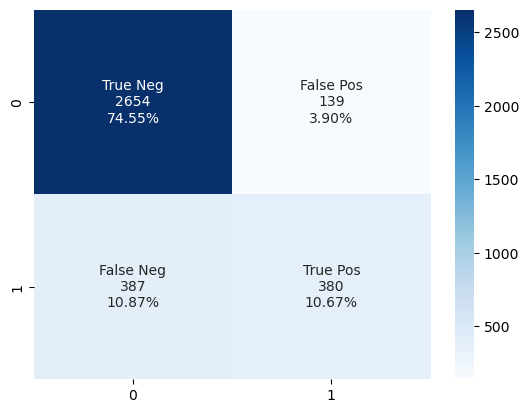

In [59]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix(test_label,submission_xgb).flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix(test_label,submission_xgb).flatten()/np.sum(confusion_matrix(test_label,submission_xgb))]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix(test_label,submission_xgb),fmt='', cmap='Blues', annot=labels)

https://github.com/arpcode/SMOTE-ADA-BOOST-COBRA/blob/main/Notebooks/SmoteAdaBoostedCC.ipynb

#### K-Fold Validation

In [60]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#### Train Acuracy

In [61]:
#Train Acuracy
# k-fold cross validation evaluation of xgboost model
from numpy import loadtxt
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(xgb_model, intermediate_output, train_label1, cv=kfold)
print("Accuracy: %.2f%%" % (results.mean()*100))

Accuracy: 85.14%


#### Test Accuracy

In [62]:
#Test Accuracy
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
test_results = cross_val_score(xgb_model, intermediate_test_output, test_label, cv=kfold)
#Test_results = cross_val_score(xgb_model, intermediate_output, val_label1, cv=kfold)
#cv_results = cross_validate(xgb_model, X, y, cv=kfold, scoring=accuracy, verbose=10)
print("Accuracy: %.2f%%" % (test_results.mean()*100))


Accuracy: 82.36%
